In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="physicsmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
physicsFOSID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [8]:
physicsFOSID = physicsFOSID.filter(physicsFOSID["Domain"]=="Physics").collect()

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(physicsFOSID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+--------+-------+
|  FOS_ID| Domain|
+--------+-------+
|24890656|Physics|
|97355855|Physics|
+--------+-------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [16]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
papers_filtered1 = papers_filtered.select(["PaperID","EstimatedCount","Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [19]:
(sample1,sample2) = papers_filtered1.randomSplit([0.3,0.7])

In [20]:
sample1.count()

1535553

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [23]:
papers_filtered1.select(["EstimatedCount"]).show(4)

+--------------+
|EstimatedCount|
+--------------+
|             0|
|            14|
|            92|
|            10|
+--------------+
only showing top 4 rows



In [29]:
sample1_pd = sample1.toPandas()

In [31]:
import numpy as np


In [33]:
y_est = np.array(sample1_pd["EstimatedCount"])
y_act = np.array(sample1_pd["label"])

## Comparison with Microsoft Predictions

In [34]:
print('Mean Absolute Error of EstimatedCount:', metrics.mean_absolute_error(y_act, y_est))
print('Mean Squared Error of EstimatedCount:', metrics.mean_squared_error(y_act, y_est))
print('Root Mean Squared of with EstimatedCount:', np.sqrt(metrics.mean_squared_error(y_act, y_est)))

('Mean Absolute Error of EstimatedCount:', 3.965429392538063)
('Mean Squared Error of EstimatedCount:', 2919.0545471240653)
('Root Mean Squared of with EstimatedCount:', 54.02827544095837)


In [38]:
sample1_pd = sample1_pd.drop(["PaperID","EstimatedCount"],axis=1)

In [39]:
sample1_pd.shape

(1535553, 12)

In [41]:
X = sample1_pd.iloc[:, 0:11].values
y = sample1_pd.iloc[:, 11].values

In [43]:
from sklearn.model_selection import StratifiedKFold

## Random Forest Regression with Stratified Kfold(5 splits)

In [44]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('TRAIN:', array([  20409,   23213,   27521, ..., 1535550, 1535551, 1535552]), 'TEST:', array([      0,       1,       2, ..., 1526371, 1526649, 1527465]))
('Mean Absolute Error:', 5.969905199874501)
('Mean Squared Error:', 5420.222071845926)
('Root Mean Squared Error:', 73.62215747888624)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([  20409,   23213,   27521, ..., 1508693, 1521241, 1522347]))
('Mean Absolute Error:', 3.5672098021885805)
('Mean Squared Error:', 292.38442415241605)
('Root Mean Squared Error:', 17.099252151846176)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([ 125348,  160781,  181253, ..., 1499402, 1521734, 1531224]))
('Mean Absolute Error:', 3.455229310805349)
('Mean Squared Error:', 208.75396112612813)
('Root Mean Squared Error:', 14.448320356571838)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([ 211208,  417393,  421871, 

In [56]:
sum_rmse  = 73.62 + 17.09 + 14.44 + 12.22 + 14.24
mean_rmse = sum_rmse/5
mean_rmse

26.322000000000003

## Random Forest Regression with Kfold(5 splits)

In [49]:
from sklearn.model_selection import KFold

In [50]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [51]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 307111,  307112,  307113, ..., 1535550, 1535551, 1535552]), 'TEST:', array([     0,      1,      2, ..., 307108, 307109, 307110]))
('Mean Absolute Error:', 3.9116960049450986)
('Mean Squared Error:', 2272.7248394197563)
('Root Mean Squared Error:', 47.67310394152825)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([307111, 307112, 307113, ..., 614219, 614220, 614221]))
('Mean Absolute Error:', 4.921502519401644)
('Mean Squared Error:', 488.6088037054514)
('Root Mean Squared Error:', 22.104497363782137)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([614222, 614223, 614224, ..., 921330, 921331, 921332]))
('Mean Absolute Error:', 2.795160074972002)
('Mean Squared Error:', 362.09176057364726)
('Root Mean Squared Error:', 19.028708851985918)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([ 921333,  921334,  921335, ..., 1228440, 1228

In [52]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 26.759610262433615)


## XGBoost Regression model

In [57]:
import xgboost as xgb

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)

In [65]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=40
)

In [66]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

26.080070883756097

In [67]:
featureslist=sample1_pd.columns

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5,1,'Feature Importances')

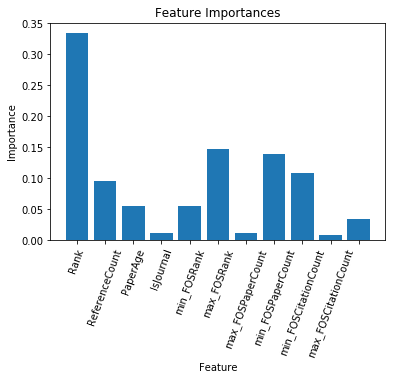

In [71]:
importances = regressor.feature_importances_
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureslist[0:10], rotation=70)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [72]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.33413
Feature: 1, Score: 0.09532
Feature: 2, Score: 0.05579
Feature: 3, Score: 0.01141
Feature: 4, Score: 0.05486
Feature: 5, Score: 0.14793
Feature: 6, Score: 0.01202
Feature: 7, Score: 0.13838
Feature: 8, Score: 0.10796
Feature: 9, Score: 0.00768
Feature: 10, Score: 0.03452


## XGBoost Regression model using KFold

In [73]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

In [74]:
rmse_list = []
for train_index, test_index in kf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=40
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error of XGBoost Kfold:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error of XGBoost Kfold:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error of XGBoost Kfold:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([ 307111,  307112,  307113, ..., 1535550, 1535551, 1535552]), 'TEST:', array([     0,      1,      2, ..., 307108, 307109, 307110]))
('Mean Absolute Error of XGBoost Kfold:', 4.140126186100619)
('Mean Squared Error of XGBoost Kfold:', 2698.1889418083488)
('Root Mean Squared Error of XGBoost Kfold:', 51.94409438818189)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([307111, 307112, 307113, ..., 614219, 614220, 614221]))
('Mean Absolute Error of XGBoost Kfold:', 5.130638829903655)
('Mean Squared Error of XGBoost Kfold:', 539.1425745868962)
('Root Mean Squared Error of XGBoost Kfold:', 23.21944389056069)
('TRAIN:', array([      0,       1,       2, ..., 1535550, 1535551, 1535552]), 'TEST:', array([614222, 614223, 614224, ..., 921330, 921331, 921332]))
('Mean Absolute Error of XGBoost Kfold:', 2.935138192414406)
('Mean Squared Error of XGBoost Kfold:', 485.47097009372595)
('Root Mean Squared Error of XGBoost Kfold:', 22.033405

In [75]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 28.813007650059337)


Text(0.5,1,'Feature Importances')

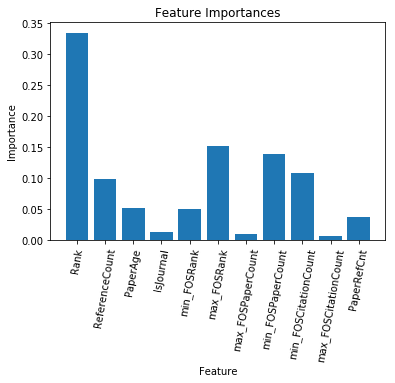

In [79]:
importances = regressor.feature_importances_
x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureslist[0:11], rotation=80)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [77]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.33452
Feature: 1, Score: 0.09907
Feature: 2, Score: 0.05209
Feature: 3, Score: 0.01196
Feature: 4, Score: 0.05050
Feature: 5, Score: 0.15091
Feature: 6, Score: 0.00969
Feature: 7, Score: 0.13946
Feature: 8, Score: 0.10864
Feature: 9, Score: 0.00564
Feature: 10, Score: 0.03751


In [84]:
import pandas as pd

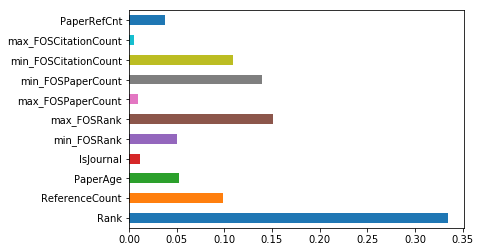

In [85]:
(pd.Series(importances, index=featureslist[0:11]).plot(kind='barh')) 